# CAPÍTULO 4 APARTADO 2 - ANÁLISIS VARIABLES

In [5]:
import numpy as np
import pandas as pd
import urllib.request

# Dataset
url = "https://github.com/carmenrebollo/deteccion_outliers/raw/main/german.data-numeric"
file_path, _ = urllib.request.urlretrieve(url)
data = np.genfromtxt(file_path)

# Se convierten los datos a un DataFrame de Pandas
df = pd.DataFrame(data)
# Etadísticas descriptivas
descriptivos = df.describe().T
# Matriz de correlación
correlaciones = df.corr()
# Resultados
print(descriptivos)
print(correlaciones)

     count    mean        std   min   25%   50%   75%    max
0   1000.0   2.577   1.257638   1.0   1.0   2.0   4.0    4.0
1   1000.0  20.903  12.058814   4.0  12.0  18.0  24.0   72.0
2   1000.0   2.545   1.083120   0.0   2.0   2.0   4.0    4.0
3   1000.0  32.711  28.252605   2.0  14.0  23.0  40.0  184.0
4   1000.0   2.105   1.580023   1.0   1.0   1.0   3.0    5.0
5   1000.0   3.384   1.208306   1.0   3.0   3.0   5.0    5.0
6   1000.0   2.682   0.708080   1.0   2.0   3.0   3.0    4.0
7   1000.0   2.845   1.103718   1.0   2.0   3.0   4.0    4.0
8   1000.0   2.358   1.050209   1.0   1.0   2.0   3.0    4.0
9   1000.0  35.546  11.375469  19.0  27.0  33.0  42.0   75.0
10  1000.0   2.675   0.705601   1.0   3.0   3.0   3.0    3.0
11  1000.0   1.407   0.577654   1.0   1.0   1.0   2.0    4.0
12  1000.0   1.155   0.362086   1.0   1.0   1.0   1.0    2.0
13  1000.0   1.404   0.490943   1.0   1.0   1.0   2.0    2.0
14  1000.0   1.037   0.188856   1.0   1.0   1.0   1.0    2.0
15  1000.0   0.234   0.4

# CAPÍTULO 4 APARTADO 3 - IMPLEMENTACIÓN GMM

Número de outliers detectados: 50
Porcentaje de outliers: 5.0 %
Número de observaciones anómalas correctas: 15
Matriz de Confusión:
[[665  35]
 [  8  15]]


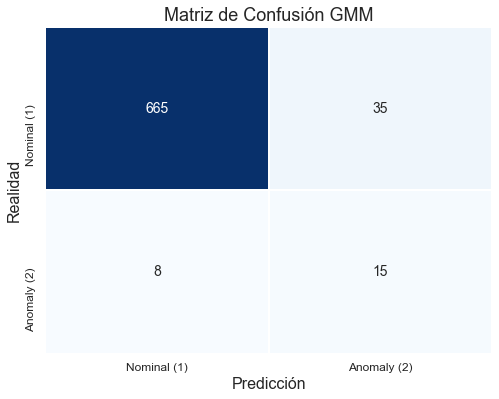

Accuracy: 0.9405255878284924
Sensibilidad: 0.6521739130434783
Especificidad: 0.95


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Se divide el conjunto de datos en características y etiquetas
X = data[:, :-1]
y = data[:, -1]

# Se normalizan los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Se ajusta el modelo de mezcla gaussiana
gmm = GaussianMixture(n_components=1, random_state=42)
gmm.fit(X_scaled)

# Se calcula la probabilidad de cada punto de datos bajo el modelo
probabilities = gmm.score_samples(X_scaled)
threshold = np.percentile(probabilities, 5)  # Se elige el 5% como umbral

# Se identifican los outliers
outliers = X_scaled[probabilities < threshold]
num_outliers = len(outliers)

# Número total de datos
total_samples = len(data)

# Se calcula el porcentaje de outliers
porcentaje_outliers = (num_outliers / total_samples) * 100

# Se visualizan resultados
print("Número de outliers detectados:", num_outliers)
print("Porcentaje de outliers:", porcentaje_outliers, "%")

# Se seleccionan las observaciones anómalas correctamente identificadas dentro de la muestra original
observaciones_anomalas_correctas = X[(probabilities < threshold) & (y == 2)]
num_observaciones_anomalas_correctas = len(observaciones_anomalas_correctas)
print("Número de observaciones anómalas correctas:", num_observaciones_anomalas_correctas)

# Verificar si se necesitan observaciones adicionales. Recuerdo que cogemos una muestra de 23 observaciones de clase 2 entre las que incluyo las correctamente seleccionadas.
if num_observaciones_anomalas_correctas < 23:
    indices_clase_2 = np.where(y == 2)[0]
    # Se excluyen las ya seleccionadas como anomalas
    indices_clase_2 = np.setdiff1d(indices_clase_2, np.where((probabilities < threshold) & (y == 2))[0])
    indices_muestras_aleatorias = np.random.choice(indices_clase_2, size=23 - num_observaciones_anomalas_correctas, replace=False)
    observaciones_aleatorias = X[indices_muestras_aleatorias]
    # Combinamos observaciones anómalas correctas y aleatorias
    observaciones_prueba = np.concatenate((observaciones_anomalas_correctas, observaciones_aleatorias))
    y_prueba = np.hstack((np.full(len(observaciones_anomalas_correctas), 2), np.full(len(observaciones_aleatorias), 2)))
else:
    observaciones_prueba = observaciones_anomalas_correctas
    y_prueba = np.full(num_observaciones_anomalas_correctas, 2)

# Añadimos todas las observaciones de la clase 1 a la muestra
observaciones_clase_1 = X[y == 1]
observaciones_prueba = np.concatenate((observaciones_prueba, observaciones_clase_1))
y_prueba = np.hstack((y_prueba, np.full(len(observaciones_clase_1), 1)))

# Predicción: 1 si no es outlier, 2 si es outlier
probabilidades_prueba = gmm.score_samples(scaler.transform(observaciones_prueba))
y_pred_prueba = np.ones(len(observaciones_prueba))
y_pred_prueba[probabilidades_prueba < threshold] = 2

# Se calcula la matriz de confusión
conf_matrix_prueba = confusion_matrix(y_prueba, y_pred_prueba, labels=[1, 2])

# Matriz confusión
print("Matriz de Confusión:")
print(conf_matrix_prueba)

# Plot más visual de esta matriz
class_labels = ["Nominal (1)", "Anomaly (2)"]
conf_matrix_df = pd.DataFrame(conf_matrix_prueba, index=class_labels, columns=class_labels)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=0.5, annot_kws={"size": 14})

# Etiquetas y título
plt.xlabel('Predicción', fontsize=16)
plt.ylabel('Realidad', fontsize=16)
plt.title('Matriz de Confusión GMM', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Visualizamos
plt.show()
from sklearn.metrics import precision_score, recall_score, f1_score

# Métricas de precisión, recall y f1-score para las observaciones de prueba
precision = precision_score(y_prueba, y_pred_prueba, pos_label=2)  # Pos_label es la clase anómala
recall = recall_score(y_prueba, y_pred_prueba, pos_label=2)
f1 = f1_score(y_prueba, y_pred_prueba, pos_label=2)
accuracy = (conf_matrix_prueba[0, 0] + conf_matrix_prueba[1, 1]) / np.sum(conf_matrix_prueba)
def specificity_score(y_true, y_pred, pos_label):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, pos_label])
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    specificity = TN / (TN + FP)
    return specificity

specificity = specificity_score(y_prueba, y_pred_prueba, pos_label=2)


# Resultados
print("Accuracy:", accuracy)
print("Sensibilidad:", recall)
print("Especificidad:", specificity)

# CAPÍTULO 4 APARTADO 4 - IMPLEMENTACIÓN PPCA

Número de outliers: 50
Porcentaje de outliers: 5.00%
Número de observaciones anómalas correctas: 12
Matriz de Confusión Ajustada:
[[662  38]
 [ 11  12]]


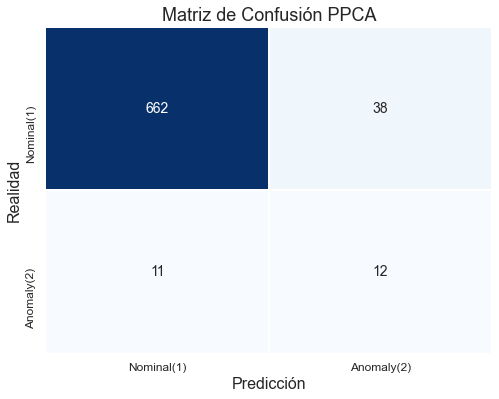

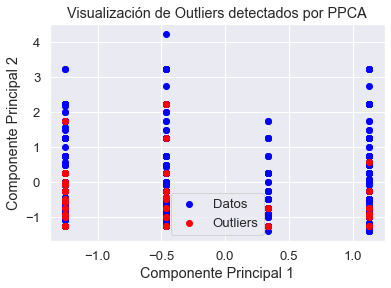

Especificidad: 0.9457142857142857
Sensibilidad: 0.5217391304347826
Accuracy: 0.9322268326417704


In [7]:
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Se divide el conjunto de datos en características y etiquetas
y = data[:, -1].astype(int)
X = data[:, :-1]

# Se normalizan los datos (aunque para PPCA es opcional, conviene)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Se aplica PPCA
ppca = FactorAnalysis(svd_method='lapack')
ppca.fit(scaled_data)

# Se obtienen las matrices de cargas factoriales
loadings = ppca.components_

# Se reconstruyen los datos multiplicando los datos transformados por las cargas factoriales
reconstructed_data = np.dot(ppca.transform(scaled_data), loadings) + ppca.mean_

# Calculamos el error de reconstrucción
reconstruction_errors = np.sum((scaled_data - reconstructed_data)**2, axis=1)

# Se establece el umbral para identificar outliers
threshold = np.percentile(reconstruction_errors, 95)

# Índices de los outliers
outlier_indices = np.where(reconstruction_errors > threshold)[0]

# Número de outliers
num_outliers = len(outlier_indices)

# Porcentaje de outliers
percentage_outliers = (num_outliers / len(data)) * 100

print("Número de outliers:", num_outliers)
print("Porcentaje de outliers: {:.2f}%".format(percentage_outliers))

# Predicción: 1 si no es outlier, 2 si es outlier
y_pred = np.ones(len(data))  # Inicializar todas las predicciones como no-outliers
y_pred[outlier_indices] = 2  # Marcar los outliers como clase 2

# SE SIGUE LA MISMA DINÁMICA QUE EN GMM PARA OBTENER LA MUESTRA

# Se seleccionan las observaciones anómalas correctamente identificadas dentro de la muestra original
probabilities = reconstruction_errors  # Probabilidades basadas en los errores de reconstrucción
observaciones_anomalas_correctas = X[(probabilities > threshold) & (y == 2)]
num_observaciones_anomalas_correctas = len(observaciones_anomalas_correctas)
print("Número de observaciones anómalas correctas:", num_observaciones_anomalas_correctas)

# Se verifica si se necesitan observaciones adicionales
if num_observaciones_anomalas_correctas < 23:
    indices_clase_2 = np.where(y == 2)[0]
    # Excluir las ya seleccionadas como anomalas
    indices_clase_2 = np.setdiff1d(indices_clase_2, np.where((probabilities > threshold) & (y == 2))[0])
    indices_muestras_aleatorias = np.random.choice(indices_clase_2, size=23 - num_observaciones_anomalas_correctas, replace=False)
    observaciones_aleatorias = X[indices_muestras_aleatorias]
    # Combinar observaciones anómalas correctas y aleatorias
    observaciones_prueba = np.concatenate((observaciones_anomalas_correctas, observaciones_aleatorias))
    y_prueba = np.hstack((np.full(len(observaciones_anomalas_correctas), 2), np.full(len(observaciones_aleatorias), 2)))
else:
    observaciones_prueba = observaciones_anomalas_correctas
    y_prueba = np.full(num_observaciones_anomalas_correctas, 2)

# Se añaden todas las observaciones de la clase 1 a la muestra
observaciones_clase_1 = X[y == 1]
observaciones_prueba = np.concatenate((observaciones_prueba, observaciones_clase_1))
y_prueba = np.hstack((y_prueba, np.full(len(observaciones_clase_1), 1)))

# Se calculan las probabilidades de la muestra de prueba
scaled_observaciones_prueba = scaler.transform(observaciones_prueba)
reconstruction_errors_prueba = np.sum((scaled_observaciones_prueba - np.dot(ppca.transform(scaled_observaciones_prueba), loadings) - ppca.mean_)**2, axis=1)

# Predicción en la muestra de prueba
y_pred_prueba = np.ones(len(observaciones_prueba))
y_pred_prueba[reconstruction_errors_prueba > threshold] = 2

# Matriz de confusión
conf_matrix = confusion_matrix(y_prueba, y_pred_prueba, labels=[1, 2])
print("Matriz de Confusión Ajustada:")
print(conf_matrix)

# Etiquetas de las clases
class_labels = ["Nominal(1)", "Anomaly(2)"]

# Visualizar mejor matriz confusión, creo un plot
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajustar el tamaño de la fuente
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=0.5, annot_kws={"size": 14})

# Etiquetas y título
plt.xlabel('Predicción', fontsize=16)
plt.ylabel('Realidad', fontsize=16)
plt.title('Matriz de Confusión PPCA', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Se visualiza
plt.show()

# Visualización de outliers detectados por PPCA
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c='blue', label='Datos')
plt.scatter(scaled_data[outlier_indices, 0], scaled_data[outlier_indices, 1], c='red', label='Outliers')
plt.legend()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Outliers detectados por PPCA')
plt.show()

# Cálculo métricas
precision = precision_score(y_prueba, y_pred_prueba, pos_label=2)
recall = recall_score(y_prueba, y_pred_prueba, pos_label=2)
f1 = f1_score(y_prueba, y_pred_prueba, pos_label=2)
accuracy = accuracy_score(y_prueba, y_pred_prueba)
def specificity_score(y_true, y_pred, pos_label):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, pos_label])
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    specificity = TN / (TN + FP)
    return specificity

specificity = specificity_score(y_prueba, y_pred_prueba, pos_label=2)

# Métricas
print("Especificidad:", specificity)
print("Sensibilidad:", recall)
print("Accuracy:", accuracy)

# CAPÍTULO 4 APARTADO 5 - IMPLEMENTACIÓN MAHALANOBIS DISTANCE

Número de outliers detectados: 50
Porcentaje de outliers: 5.0 %
Número de observaciones anómalas correctas: 15
Matriz de Confusión para las observaciones de prueba:
[[665  35]
 [  8  15]]


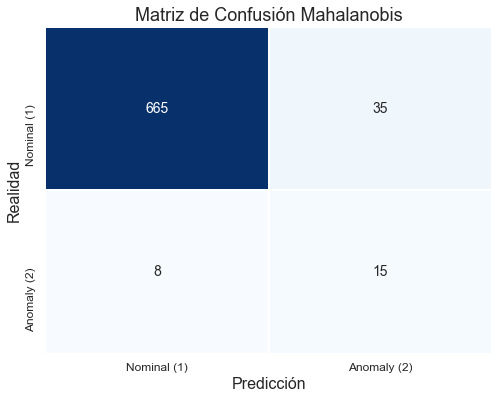

Especificidad: 0.95
Sensibilidad: 0.6521739130434783
Accuracy: 0.9405255878284924


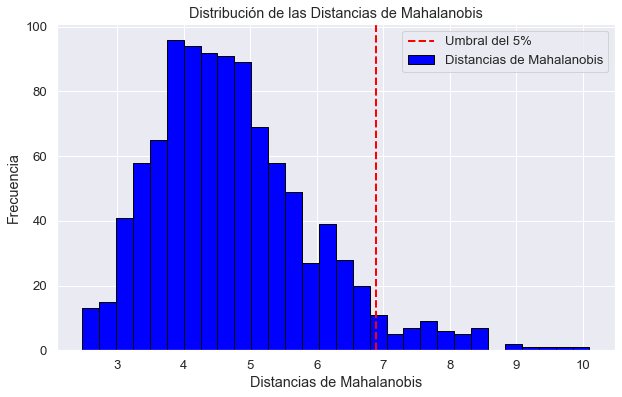

In [8]:
from scipy.spatial.distance import mahalanobis


# Se divide el conjunto de datos en características y etiquetas
X = data[:, :-1]
y = data[:, -1]

# Se normalizan los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculo la media y la matriz de covarianza de los datos
mean = np.mean(X_scaled, axis=0)
covariance_matrix = np.cov(X_scaled, rowvar=False)

# Se invierte la matriz de covarianza
inv_covariance_matrix = np.linalg.inv(covariance_matrix)

# Cálculo distancia de Mahalanobis para cada punto de datos
mahalanobis_distances = [mahalanobis(x, mean, inv_covariance_matrix) for x in X_scaled]

# Umbral del 5% para identificar outliers
threshold = np.percentile(mahalanobis_distances, 95)

# Se identifican los outliers
outliers = np.array(mahalanobis_distances) > threshold
num_outliers = np.sum(outliers)

# Número total de datos
total_samples = len(data)

# Porcentaje de outliers
percentage_outliers = (num_outliers / total_samples) * 100

print("Número de outliers detectados:", num_outliers)
print("Porcentaje de outliers:", percentage_outliers, "%")

# Predicción: 1 si no es outlier, 2 si es outlier
y_pred = np.ones(len(data))
y_pred[outliers] = 2 

# OBTENGO LA MUESTRA CON LOS MISMOS PASOS QUE EN GMM Y PPCA, YA EXPLICADOS

# Se selecciona las observaciones anómalas correctamente identificadas dentro de la muestra original
observaciones_anomalas_correctas = X[(outliers) & (y == 2)]
num_observaciones_anomalas_correctas = len(observaciones_anomalas_correctas)
print("Número de observaciones anómalas correctas:", num_observaciones_anomalas_correctas)

# Se verifica si se necesitan observaciones adicionales
if num_observaciones_anomalas_correctas < 23:
    indices_clase_2 = np.where(y == 2)[0]
    # Excluir las ya seleccionadas como anomalas
    indices_clase_2 = np.setdiff1d(indices_clase_2, np.where((outliers) & (y == 2))[0])
    indices_muestras_aleatorias = np.random.choice(indices_clase_2, size=23 - num_observaciones_anomalas_correctas, replace=False)
    observaciones_aleatorias = X[indices_muestras_aleatorias]
    # Combinar observaciones anómalas correctas y aleatorias
    observaciones_prueba = np.concatenate((observaciones_anomalas_correctas, observaciones_aleatorias))
    y_prueba = np.hstack((np.full(len(observaciones_anomalas_correctas), 2), np.full(len(observaciones_aleatorias), 2)))
else:
    observaciones_prueba = observaciones_anomalas_correctas
    y_prueba = np.full(num_observaciones_anomalas_correctas, 2)

# Se añaden todas las observaciones de la clase 1 a la muestra
observaciones_clase_1 = X[y == 1]
observaciones_prueba = np.concatenate((observaciones_prueba, observaciones_clase_1))
y_prueba = np.hstack((y_prueba, np.full(len(observaciones_clase_1), 1)))

# Cálculo distancias de Mahalanobis para la muestra
mahalanobis_distances_prueba = [mahalanobis(x, mean, inv_covariance_matrix) for x in scaler.transform(observaciones_prueba)]

# Predicción en la muestra
y_pred_prueba = np.ones(len(observaciones_prueba))
y_pred_prueba[np.array(mahalanobis_distances_prueba) > threshold] = 2

# Matriz de confusión
conf_matrix_prueba = confusion_matrix(y_prueba, y_pred_prueba, labels=[1, 2])
print("Matriz de Confusión para las observaciones de prueba:")
print(conf_matrix_prueba)

# Visualizamos con un plot
class_labels = ["Nominal (1)", "Anomaly (2)"]
conf_matrix_df = pd.DataFrame(conf_matrix_prueba, index=class_labels, columns=class_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=0.5, annot_kws={"size": 14})

# Etiquetas y título
plt.xlabel('Predicción', fontsize=16)
plt.ylabel('Realidad', fontsize=16)
plt.title('Matriz de Confusión Mahalanobis', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Visualizar
plt.show()

# Calcular las métricas
precision = precision_score(y_prueba, y_pred_prueba, pos_label=2)
recall = recall_score(y_prueba, y_pred_prueba, pos_label=2)
f1 = f1_score(y_prueba, y_pred_prueba, pos_label=2)
accuracy = accuracy_score(y_prueba, y_pred_prueba)

def specificity_score(y_true, y_pred, pos_label):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, pos_label])
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    specificity = TN / (TN + FP)
    return specificity

specificity = specificity_score(y_prueba, y_pred_prueba, pos_label=2)

# Métricas
print("Especificidad:", specificity)
print("Sensibilidad:", recall)
print("Accuracy:", accuracy)


# Creo el histograma
plt.figure(figsize=(10, 6))
plt.hist(mahalanobis_distances, bins=30, color='blue', edgecolor='black')

# línea vertical para marcar el umbral del 5%
plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2)

#Etiquetas
plt.xlabel('Distancias de Mahalanobis')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Distancias de Mahalanobis')
plt.legend(['Umbral del 5%', 'Distancias de Mahalanobis'])
plt.show()


# CAPÍTULO 4 APARTADO 6 - IMPLEMENTACIÓN LOF

Número de outliers: 37
Porcentaje de outliers: 5.12%
Matriz de Confusión en la muestra de prueba:
[[671  29]
 [ 15   8]]
Sensibilidad: 0.348
Exactitud: 0.939
Especificidad: 0.959


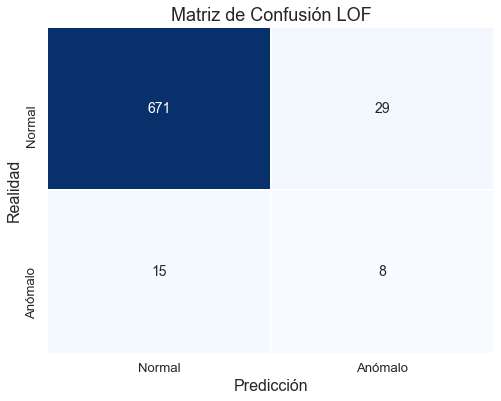

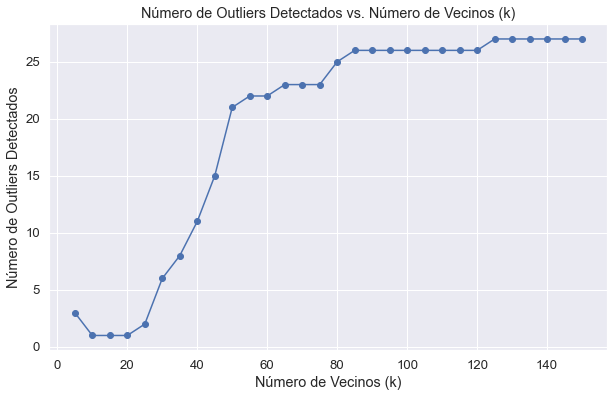

In [9]:
from sklearn.neighbors import LocalOutlierFactor

# Se dividen los datos en características y etiquetas
X = data[:, :-1]
y = data[:, -1]

# Se Normalizan los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Primero, se aplica Local Outlier Factor inicialmente para identificar los valores anómalos correctamente
lof_initial = LocalOutlierFactor(n_neighbors=50, contamination=0.05)
outlier_labels_initial = lof_initial.fit_predict(X_scaled)
outlier_indices_initial = np.where(outlier_labels_initial == -1)[0]

# OBTENEMOS LA MUESTRA COMO CON LAS TÉCNICAS ANTERIORES
# Se seleccionan los valores anómalos correctamente predichos de clase 2
anomalous_correct_indices = outlier_indices_initial[y[outlier_indices_initial] == 2]
num_anomalous_correct = len(anomalous_correct_indices)

# Se seleccionan observaciones adicionales de clase 2 aleatoriamente hasta llegar a 23
if num_anomalous_correct < 23:
    additional_indices_needed = 23 - num_anomalous_correct
    other_class_2_indices = np.where(y == 2)[0]
    additional_indices = np.setdiff1d(other_class_2_indices, anomalous_correct_indices)
    additional_indices_sampled = np.random.choice(additional_indices, additional_indices_needed, replace=False)
    class_2_indices = np.hstack((anomalous_correct_indices, additional_indices_sampled))
else:
    class_2_indices = anomalous_correct_indices[:23]

# Se seleccionan todas las observaciones de clase 1
class_1_indices = np.where(y == 1)[0]

# Se combinan las observaciones seleccionadas
selected_indices = np.hstack((class_1_indices, class_2_indices))
X_combined = X_scaled[selected_indices]
y_combined = y[selected_indices]

# Se aplica Local Outlier Factor a las observaciones seleccionadas
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.05)
outlier_labels = lof.fit_predict(X_combined)

# Se identifican los outliers
outlier_indices = np.where(outlier_labels == -1)[0]
num_outliers = len(outlier_indices)

# Porcentaje de outliers
percentage_outliers = (num_outliers / len(X_combined)) * 100

print("Número de outliers:", num_outliers)
print("Porcentaje de outliers: {:.2f}%".format(percentage_outliers))

# Matriz de confusión
outlier_labels_binary = (outlier_labels == -1).astype(int)
y_binary = (y_combined == 2).astype(int)  # Convertir y a binario: 1 si es outlier (clase 2), 0 si es normal (clase 1)

# Matriz de confusión
conf_matrix_prueba = confusion_matrix(y_binary, outlier_labels_binary)
print("Matriz de Confusión en la muestra de prueba:")
print(conf_matrix_prueba)

# Métricas de precisión, recall, f1-score, especificidad y exactitud
precision = precision_score(y_binary, outlier_labels_binary)
recall = recall_score(y_binary, outlier_labels_binary)
f1 = f1_score(y_binary, outlier_labels_binary)
accuracy = accuracy_score(y_binary, outlier_labels_binary)

def specificity_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    specificity = TN / (TN + FP)
    return specificity

specificity = specificity_score(y_binary, outlier_labels_binary)

# Resultados
print("Sensibilidad: {:.3f}".format(recall))
print("Exactitud: {:.3f}".format(accuracy))
print("Especificidad: {:.3f}".format(specificity))


# Visualizamos matriz confusión con un plot
class_names = ['Normal', 'Anómalo']
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_prueba, annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=0.5, annot_kws={"size": 14})

# Etiquetas y título
plt.xlabel('Predicción', fontsize=16)
plt.ylabel('Realidad', fontsize=16)
plt.title('Matriz de Confusión LOF', fontsize=18)
plt.xticks(ticks=[0.5, 1.5], labels=class_names)
plt.yticks(ticks=[0.5, 1.5], labels=class_names)
plt.show()

# Gráfico del número de outliers detectados vs. número de vecinos (k)
k_values = range(5, 155, 5)
outliers_detected = []

for k in k_values:
    lof = LocalOutlierFactor(n_neighbors=k)
    y_pred = lof.fit_predict(X_scaled)
    num_outliers = np.sum(y_pred == -1)
    outliers_detected.append(num_outliers)

plt.figure(figsize=(10, 6))
plt.plot(k_values, outliers_detected, marker='o', linestyle='-')
plt.title('Número de Outliers Detectados vs. Número de Vecinos (k)')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Número de Outliers Detectados')
plt.grid(True)
plt.show()

# CAPÍTULO 4 APARTADO 7 - IMPLEMENTACIÓN IFOREST

Número de outliers detectados: 50
Porcentaje de outliers: 5.0 %
Número de observaciones anómalas correctas: 19
Matriz de Confusión para las observaciones de prueba:
[[669  31]
 [  4  19]]


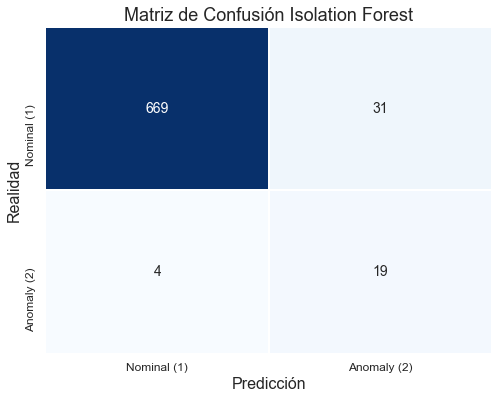

Sensibilidad: 0.8260869565217391
Exactitud: 0.9515905947441217
Especificidad: 0.9557142857142857


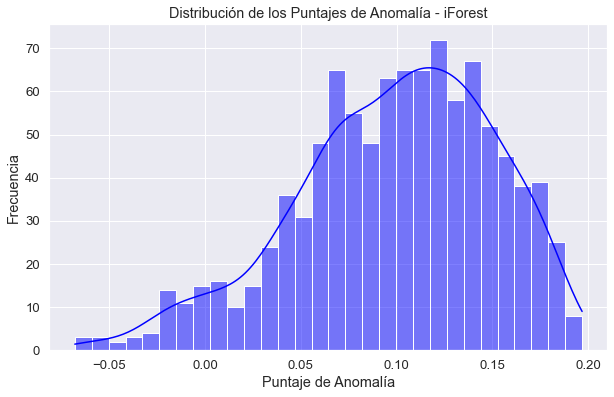

In [10]:
from sklearn.ensemble import IsolationForest

# Se divide el conjunto de datos en características y etiquetas
X = data[:, :-1]
y = data[:, -1]

# Se normalizan los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Se ajusta el modelo de Isolation Forest
iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42) # Cojo 100 estimadores por el estudio que se referencia en el trabajo
iforest.fit(X_scaled)

# Se identifican los outliers
outliers = X_scaled[iforest.predict(X_scaled) == -1]
num_outliers = len(outliers)

# Número total de datos
total_samples = len(data)

# Porcentaje de outliers
porcentaje_outliers = (num_outliers / total_samples) * 100

# Se visualizan resultados
print("Número de outliers detectados:", num_outliers)
print("Porcentaje de outliers:", porcentaje_outliers, "%")

# OBTENEMOS MUESTRA COMO EN LAS OTRAS TÉCNICAS

# Seleccionar las observaciones anómalas correctamente identificadas dentro de la muestra original
observaciones_anomalas_correctas = X[(iforest.predict(X_scaled) == -1) & (y == 2)]
num_observaciones_anomalas_correctas = len(observaciones_anomalas_correctas)
print("Número de observaciones anómalas correctas:", num_observaciones_anomalas_correctas)

# Verificar si se necesitan observaciones adicionales
if num_observaciones_anomalas_correctas < 23:
    indices_clase_2 = np.where(y == 2)[0]
    # Excluir las ya seleccionadas como anomalas
    indices_clase_2 = np.setdiff1d(indices_clase_2, np.where((iforest.predict(X_scaled) == -1) & (y == 2))[0])
    indices_muestras_aleatorias = np.random.choice(indices_clase_2, size=23 - num_observaciones_anomalas_correctas, replace=False)
    observaciones_aleatorias = X[indices_muestras_aleatorias]
    # Combinar observaciones anómalas correctas y aleatorias
    observaciones_prueba = np.concatenate((observaciones_anomalas_correctas, observaciones_aleatorias))
    y_prueba = np.hstack((np.full(len(observaciones_anomalas_correctas), 2), np.full(len(observaciones_aleatorias), 2)))
else:
    observaciones_prueba = observaciones_anomalas_correctas
    y_prueba = np.full(num_observaciones_anomalas_correctas, 2)

# Añadimos todas las observaciones de la clase 1 a la muestra
observaciones_clase_1 = X[y == 1]
observaciones_prueba = np.concatenate((observaciones_prueba, observaciones_clase_1))
y_prueba = np.hstack((y_prueba, np.full(len(observaciones_clase_1), 1)))

# Predicción: 1 si no es outlier, 2 si es outlier
y_pred_prueba = np.ones(len(observaciones_prueba))
y_pred_prueba[iforest.predict(scaler.transform(observaciones_prueba)) == -1] = 2

# Calcular la matriz de confusión para las observaciones de prueba
conf_matrix_prueba = confusion_matrix(y_prueba, y_pred_prueba, labels=[1, 2])

# Imprimir la matriz de confusión para las observaciones de prueba
print("Matriz de Confusión para las observaciones de prueba:")
print(conf_matrix_prueba)

# Visualizo matriz de confusión con plot
class_labels = ["Nominal (1)", "Anomaly (2)"]
conf_matrix_df = pd.DataFrame(conf_matrix_prueba, index=class_labels, columns=class_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", cbar=False, linewidths=0.5, annot_kws={"size": 14})

# Etiquetas y título
plt.xlabel('Predicción', fontsize=16)
plt.ylabel('Realidad', fontsize=16)
plt.title('Matriz de Confusión Isolation Forest', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Métricas cálculo
precision = precision_score(y_prueba, y_pred_prueba, pos_label=2)  # Pos_label es la clase anómala
recall = recall_score(y_prueba, y_pred_prueba, pos_label=2)
f1 = f1_score(y_prueba, y_pred_prueba, pos_label=2)
accuracy = accuracy_score(y_prueba, y_pred_prueba)
tn, fp, fn, tp = conf_matrix_prueba.ravel()
specificity = tn / (tn + fp)

# Resultados
print("Sensibilidad:", recall)
print("Exactitud:", accuracy)
print("Especificidad:", specificity)

# Calculamos los puntajes de anomalía para visualizarlo en un gráfico
anomaly_scores = iforest.decision_function(X_scaled)

# Se crea el histograma de los puntajes de anomalía
plt.figure(figsize=(10, 6))
sns.histplot(anomaly_scores, bins=30, kde=True, color='blue')
plt.title('Distribución de los Puntajes de Anomalía - iForest')
plt.xlabel('Puntaje de Anomalía')
plt.ylabel('Frecuencia')

plt.show()


# CAPÍTULO 4 APARTADO 8 - COMPARATIVA TÉCNICAS MÉTRICAS

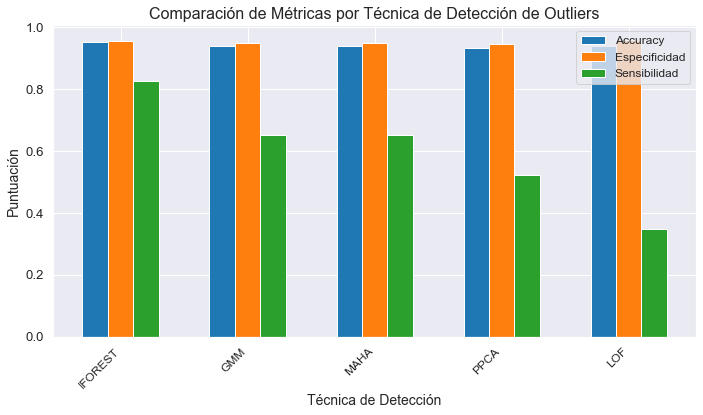

In [11]:
# Métricas obtenidas para cada técnica
tecnicas = ['IFOREST', 'GMM', 'MAHA', 'PPCA', 'LOF']
Accuracy = [0.95159, 0.94, 0.940525, 0.9322, 0.939]
Especificidad = [0.9557, 0.95, 0.95, 0.9457, 0.959]
Sensibilidad = [0.82608, 0.652, 0.65217, 0.5217, 0.348]

# Configuración de colores
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Configuración de barras
bar_width = 0.2
index = np.arange(len(tecnicas))

# Gráfico comparativo
plt.figure(figsize=(10, 6))

# Dibujo de barras
plt.bar(index - bar_width, Accuracy, bar_width, label='Accuracy', color=colors[0])
plt.bar(index, Especificidad, bar_width, label='Especificidad', color=colors[1])
plt.bar(index + bar_width, Sensibilidad, bar_width, label='Sensibilidad', color=colors[2])

# Etiquetas de título y ejes
plt.title('Comparación de Métricas por Técnica de Detección de Outliers', fontsize=16)
plt.xlabel('Técnica de Detección', fontsize=14)
plt.ylabel('Puntuación', fontsize=14)

plt.legend(fontsize=12)
plt.xticks(index, tecnicas, rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Visualizamoos
plt.show()
